##Unstructured Pruning

In [ ]:
"""
task1_unstructured_pruning.py

Complete script for:
- training VGG-11 on CIFAR-10
- magnitude-based unstructured pruning (from scratch)
- layer-wise sensitivity analysis
- automatic allocation of per-layer sparsities to reach target overall sparsity (~70%)
- visualizations and model saving

Usage:
    python task1_unstructured_pruning.py

Requirements:
    torch, torchvision, matplotlib, numpy, tqdm
"""

import os
import copy
import math
import random
from typing import List, Dict, Tuple

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import vgg11

# -----------------------
# CONFIG
# -----------------------
SEED = 42
BATCH_SIZE = 128
NUM_WORKERS = 4
LR = 0.01
MOMENTUM = 0.9
WEIGHT_DECAY = 5e-4
NUM_EPOCHS = 12         # use small value for quick testing; increase for better baseline
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TARGET_OVERALL_SPARSITY = 0.70  # 70%
SENSITIVITY_SPARSITIES = [0.2, 0.4, 0.6, 0.8]  # values to probe per-layer sensitivity
OUTPUT_DIR = "task1_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [ ]:
# -----------------------
# Utilities & Setup
# -----------------------
def set_seed(seed: int = SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed()

In [ ]:
# -----------------------
# Data loaders (CIFAR-10)
# -----------------------
def get_dataloaders(batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    # Standard CIFAR-10 transforms (resize to 224 to match VGG input)
    transform_train = transforms.Compose([
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ])
    transform_test = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return trainloader, testloader

In [ ]:
# -----------------------
# Model
# -----------------------
def build_vgg11(num_classes=10):
    # instantiate VGG11; we do not load ImageNet weights (training from scratch)
    model = vgg11(weights=None)  # torchvision.models.vgg11(weights=None)
    # Adapt classifier for CIFAR-10 (default VGG11 classifier is 1000 outputs)
    model.classifier[-1] = nn.Linear(in_features=model.classifier[-1].in_features, out_features=num_classes)
    return model

In [ ]:
# -----------------------
# Training / Evaluation
# -----------------------
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    total, correct = 0, 0
    pbar = tqdm(dataloader, desc="Train", leave=False)
    for inputs, targets in pbar:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = outputs.max(1)
        total += targets.size(0)
        correct += preds.eq(targets).sum().item()
        pbar.set_postfix(loss=running_loss/total, acc=100.*correct/total)
    return running_loss / total, 100.0 * correct / total

In [ ]:
def evaluate(model, dataloader, device):
    model.eval()
    total, correct = 0, 0
    loss_total = 0.0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss_total += loss.item() * inputs.size(0)
            _, preds = outputs.max(1)
            total += targets.size(0)
            correct += preds.eq(targets).sum().item()
    acc = 100.0 * correct / total
    avg_loss = loss_total / total
    return avg_loss, acc

In [ ]:
# -----------------------
# Pruning utilities (from scratch)
# -----------------------
def get_prunable_layers(model: nn.Module) -> List[Tuple[str, nn.Module]]:
    """
    Return list of (name, module) for layers we will consider for pruning:
    We prune nn.Conv2d and nn.Linear weights.
    """
    prunable = []
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            prunable.append((name, module))
    return prunable

def prune_layer_magnitude(layer: nn.Module, sparsity: float) -> torch.Tensor:
    """
    In-place magnitude-based unstructured pruning for a single layer.
    Set to zero those weights whose absolute value is <= threshold computed by sparsity.
    Returns the boolean mask applied (1=kept, 0=zeroed) as a torch.Tensor of same shape as layer.weight.
    NOTE: This modifies layer.weight.data directly.
    """
    assert 0.0 <= sparsity < 1.0, "sparsity must be in [0,1)"
    with torch.no_grad():
        w = layer.weight.data.clone()
        flat = w.abs().view(-1).cpu().numpy()
        if flat.size == 0:
            mask = torch.ones_like(layer.weight.data, dtype=torch.bool)
            return mask
        k = int(math.floor(sparsity * flat.size))
        if k == 0:
            mask = torch.ones_like(layer.weight.data, dtype=torch.bool)
            return mask
        # find threshold: we want to zero the smallest k absolute values
        threshold = np.partition(flat, k - 1)[k - 1] if k > 0 else 0.0
        mask_np = (np.abs(w.cpu().numpy()) > threshold).astype(np.uint8)
        mask = torch.from_numpy(mask_np).to(layer.weight.device).bool()
        # apply mask
        layer.weight.data *= mask
        return mask

In [ ]:
def compute_overall_sparsity(model: nn.Module) -> float:
    """
    Compute fraction of zeros in prunable weights across the model.
    """
    total = 0
    zero = 0
    for _, layer in get_prunable_layers(model):
        w = layer.weight.data
        total += w.numel()
        zero += (w == 0).sum().item()
    if total == 0:
        return 0.0
    return zero / total


In [ ]:
# -----------------------
# Weight distribution plotting
# -----------------------
def plot_weight_distribution(layer: nn.Module, title: str, path: str = None, bins=120):
    w = layer.weight.data.cpu().numpy().flatten()
    plt.figure(figsize=(6,4))
    plt.hist(w, bins=bins)
    plt.title(title)
    plt.xlabel("Weight value")
    plt.ylabel("Count")
    plt.grid(True, linestyle='--', alpha=0.4)
    if path:
        plt.tight_layout()
        plt.savefig(path, dpi=150)
        plt.close()
    else:
        plt.show()


In [ ]:
# -----------------------
# Sensitivity analysis
# -----------------------
def sensitivity_analysis(model: nn.Module, testloader, device, sparsity_values=SENSITIVITY_SPARSITIES):
    """
    For each prunable layer, temporarily prune only that layer at different sparsities and measure accuracy.
    Returns a dict: layer_name -> list of (sparsity, accuracy)
    IMPORTANT: model will not be permanently modified (we use state_dict snapshot)
    """
    model = model.to(device)
    base_state = copy.deepcopy(model.state_dict())
    results = {}
    prunable = get_prunable_layers(model)

    print("Starting sensitivity analysis on {} layers...".format(len(prunable)))
    for name, layer in prunable:
        results[name] = []
        print(f"\nAnalyzing layer: {name} ({type(layer).__name__}), weight shape: {tuple(layer.weight.data.shape)}")
        for s in sparsity_values:
            model.load_state_dict(copy.deepcopy(base_state))  # restore
            # find layer in model by name -> we can use getattr step by step
            # easier: walk named_modules to find module with same name
            mod = None
            for nm, m in model.named_modules():
                if nm == name:
                    mod = m
                    break
            if mod is None:
                raise RuntimeError(f"Layer {name} not found during sensitivity test.")
            prune_layer_magnitude(mod, s)
            _, acc = evaluate(model, testloader, device)
            results[name].append((s, acc))
            print(f"  sparsity {s:.2f} -> acc {acc:.2f}%")
        # restore base state to ensure no permanent changes carried over
        model.load_state_dict(copy.deepcopy(base_state))

    return results

def plot_sensitivity_results(results: Dict[str, List[Tuple[float,float]]], path: str = None):
    plt.figure(figsize=(10,6))
    # For clarity, plot only a subset if too many layers
    for i, (layer_name, data) in enumerate(results.items()):
        spars, accs = zip(*data)
        plt.plot(spars, accs, marker='o', label=layer_name)
    plt.xlabel("Sparsity applied to single layer")
    plt.ylabel("Test Accuracy (%)")
    plt.title("Layer-wise Sensitivity to Unstructured Magnitude Pruning")
    plt.legend(fontsize='small', bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    if path:
        plt.savefig(path, dpi=150)
        plt.close()
    else:
        plt.show()

In [ ]:
# -----------------------
# Heuristic allocation of per-layer sparsities
# -----------------------
def allocate_sparsity_to_layers(results: Dict[str, List[Tuple[float,float]]], target_overall: float) -> Dict[str, float]:
    """
    Heuristic:
    - For each layer, compute sensitivity score = slope of accuracy drop across sparsities (higher slope => more sensitive)
      Implement a simple measure: sensitivity = (acc at s=0.2 - acc at s=0.8) / (0.8 - 0.2)
    - Map sensitivity to allowed sparsity: more sensitive -> lower final sparsity.
    - We then scale these allowed sparsities so that the overall sparsity across all weights reaches target_overall.
    Returns a dict layer_name -> allocated_sparsity
    """
    # Compute per-layer sensitivity and initial allowed sparsity (inversely related)
    layer_sens = {}
    for layer, vals in results.items():
        # ensure sorted by sparsity value
        vals_sorted = sorted(vals, key=lambda x: x[0])
        spars_vals = [v for v,_ in vals_sorted]
        acc_vals = [a for _,a in vals_sorted]
        # If only one value, fallback
        if len(spars_vals) >= 2:
            # approximate slope between min and max sparsity
            sens = (acc_vals[0] - acc_vals[-1]) / (spars_vals[-1] - spars_vals[0])
        else:
            sens = 0.0
        layer_sens[layer] = max(sens, 0.0)

    # Normalize sensitivity to [0,1]
    sens_values = np.array(list(layer_sens.values()), dtype=float)
    if sens_values.max() == sens_values.min():
        norm = np.ones_like(sens_values)
    else:
        norm = (sens_values - sens_values.min()) / (sens_values.max() - sens_values.min())

    # Proposed base allowed sparsity (higher for less sensitive layers)
    # allowed_sparsity = 0.2 + (1 - norm) * 0.7  -> ranges ~[0.2, 0.9]
    layer_names = list(layer_sens.keys())
    allowed = {}
    for i, ln in enumerate(layer_names):
        allowed[ln] = 0.2 + (1.0 - norm[i]) * 0.7

    # Now we must convert allowed per-layer sparsities into final per-layer sparsities
    # by accounting for layer sizes and scaling to meet the overall target.
    # Compute per-layer weight counts:
    # To get layer sizes we will ask the user model? We don't have model here. We'll compute relative by using saved masks later.
    # For now return 'allowed' as a starting point; we'll refine allocation with actual weight counts in calling code.
    return allowed

def finalize_sparsity_allocation(model: nn.Module, allowed: Dict[str, float], target_overall: float) -> Dict[str, float]:
    """
    Given allowed max sparsities per layer (allowed[ln] between 0 and 1),
    find final per-layer sparsities that satisfy overall target.

    Strategy:
    - For each layer compute number of weights n_i.
    - Start with final_s_i = allowed[ln] (clipped).
    - Compute overall sparsity; if larger than target, uniformly reduce sparsities proportional to (final_s_i).
    - If smaller than target, increase sparsities for least-sensitive layers (largest allowed - final_s).
    - This solver is heuristic and will converge quickly for our use.
    """
    prunable = get_prunable_layers(model)
    layer_names = [name for (name,_) in prunable]
    counts = {name: module.weight.data.numel() for name,module in prunable}
    # Start with allowed as initial final
    final = {name: float(np.clip(allowed.get(name, 0.5), 0.0, 0.99)) for name in layer_names}

    def compute_overall(final_map):
        total = 0
        zero = 0
        for n in layer_names:
            total += counts[n]
            zero += final_map[n] * counts[n]
        return zero / total

    curr_overall = compute_overall(final)
    # Iteratively adjust
    it = 0
    while abs(curr_overall - target_overall) > 1e-3 and it < 200:
        it += 1
        if curr_overall > target_overall:
            # overall too sparse -> reduce all final sparsities proportionally
            # compute amount to scale
            scale = target_overall / (curr_overall + 1e-12)
            for n in layer_names:
                final[n] = max(0.0, final[n] * scale)
        else:
            # not sparse enough -> increase sparsity where space is available (allowed - final)
            diffs = {n: allowed.get(n, 0.99) - final[n] for n in layer_names}
            # if no room left, break
            if all(d <= 1e-6 for d in diffs.values()):
                break
            # allocate increase proportional to diffs * counts (prefer big layers with capacity)
            total_capacity = sum(max(0.0, d) * counts[n] for n,d in diffs.items())
            if total_capacity == 0:
                break
            needed_zero_increase = (target_overall - curr_overall) * sum(counts.values())
            for n in layer_names:
                cap = max(0.0, diffs[n]) * counts[n]
                # allocate proportionally
                final[n] += (cap / (total_capacity + 1e-12)) * (needed_zero_increase / counts[n])
                # clip
                final[n] = float(np.clip(final[n], 0.0, allowed.get(n, 0.99)))
        curr_overall = compute_overall(final)

    # safety clip
    for n in layer_names:
        final[n] = float(np.clip(final[n], 0.0, 0.99))
    return final

In [ ]:
# -----------------------
# Apply final pruning plan (per-layer)
# -----------------------
def apply_pruning_plan(model: nn.Module, per_layer_sparsity: Dict[str, float]) -> Dict[str, torch.Tensor]:
    """
    For each layer, apply prune_layer_magnitude with allocated sparsity.
    Returns dict layer_name -> mask tensor.
    """
    masks = {}
    for name, module in get_prunable_layers(model):
        s = per_layer_sparsity.get(name, 0.0)
        mask = prune_layer_magnitude(module, float(s))
        masks[name] = mask
    return masks

In [ ]:
# -----------------------
# Save helper
# -----------------------
def save_model_and_metadata(model: nn.Module, masks: Dict[str, torch.Tensor], path_prefix: str):
    torch.save(model.state_dict(), f"{path_prefix}_state.pth")
    # Save masks and metadata
    masks_cpu = {k: v.cpu().numpy() for k,v in masks.items()}
    np.savez_compressed(f"{path_prefix}_masks.npz", **masks_cpu)
    print(f"Saved model state and masks to {path_prefix}_*")

In [ ]:
# -----------------------
# Main flow
# -----------------------
def main():
    print("Device:", DEVICE)
    trainloader, testloader = get_dataloaders()
    model = build_vgg11(num_classes=10).to(DEVICE)
    print("Model built. Prunable layers:")
    for name, layer in get_prunable_layers(model):
        print("  ", name, type(layer).__name__, tuple(layer.weight.data.shape))

    # Train baseline
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)

    best_val_acc = 0.0
    for epoch in range(1, NUM_EPOCHS + 1):
        print(f"\nEpoch {epoch}/{NUM_EPOCHS}")
        train_loss, train_acc = train_one_epoch(model, trainloader, criterion, optimizer, DEVICE)
        val_loss, val_acc = evaluate(model, testloader, DEVICE)
        print(f"Train loss {train_loss:.4f}, acc {train_acc:.2f}% | Val loss {val_loss:.4f}, acc {val_acc:.2f}%")
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, "vgg11_baseline_best.pth"))
        scheduler.step()

    print(f"Baseline finished. Best val acc: {best_val_acc:.2f}%")
    baseline_loss, baseline_acc = evaluate(model, testloader, DEVICE)
    print(f"Baseline final eval acc: {baseline_acc:.2f}%")
    baseline_sparsity = compute_overall_sparsity(model)
    print(f"Baseline overall sparsity (should be near 0): {baseline_sparsity:.4f}")

    # Visualize weight distribution for first conv layer before pruning
    prunable = get_prunable_layers(model)
    if len(prunable) > 0:
        sample_layer_name, sample_layer_mod = prunable[0]
        plot_weight_distribution(sample_layer_mod, f"Before pruning - {sample_layer_name}",
                                 path=os.path.join(OUTPUT_DIR, f"weights_before_{sample_layer_name.replace('.','_')}.png"))
        print(f"Saved weight distribution before pruning for {sample_layer_name}")

    # Sensitivity analysis
    sens_results = sensitivity_analysis(model, testloader, DEVICE, sparsity_values=SENSITIVITY_SPARSITIES)
    plot_sensitivity_results(sens_results, path=os.path.join(OUTPUT_DIR, "sensitivity_plot.png"))
    print("Saved sensitivity plot.")

    # Compute allowed sparsities based on sensitivity heuristic
    allowed = allocate_sparsity_to_layers(sens_results, TARGET_OVERALL_SPARSITY)
    # Finalize allocation using layer sizes
    final_alloc = finalize_sparsity_allocation(model, allowed, TARGET_OVERALL_SPARSITY)
    print("\nFinal per-layer sparsity allocation (pre-pruning):")
    for k,v in final_alloc.items():
        print(f"  {k}: {v:.3f}")

    # Apply final pruning and evaluate
    masks = apply_pruning_plan(model, final_alloc)
    post_prune_sparsity = compute_overall_sparsity(model)
    print(f"Overall sparsity after applying plan: {post_prune_sparsity:.4f} (target {TARGET_OVERALL_SPARSITY:.4f})")

    # Plot weight distribution after pruning for sample layer
    plot_weight_distribution(sample_layer_mod, f"After pruning - {sample_layer_name}",
                             path=os.path.join(OUTPUT_DIR, f"weights_after_{sample_layer_name.replace('.','_')}.png"))
    print(f"Saved weight distribution after pruning for {sample_layer_name}")

    # Evaluate pruned model
    pruned_loss, pruned_acc = evaluate(model, testloader, DEVICE)
    print(f"Pruned model eval -> loss: {pruned_loss:.4f}, acc: {pruned_acc:.2f}%")

    # Save model and masks
    save_model_and_metadata(model, masks, os.path.join(OUTPUT_DIR, "vgg11_pruned_70"))

    # Save a CSV-like summary for reporting
    summary_lines = [
        f"baseline_acc,{baseline_acc:.4f}",
        f"pruned_acc,{pruned_acc:.4f}",
        f"baseline_sparsity,{baseline_sparsity:.6f}",
        f"post_prune_sparsity,{post_prune_sparsity:.6f}"
    ]
    with open(os.path.join(OUTPUT_DIR, "summary.csv"), "w") as f:
        f.write("\n".join(summary_lines))
    print("Saved summary.csv")

if __name__ == "__main__":
    main()


Device: cuda


100%|██████████| 170M/170M [00:14<00:00, 12.1MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Model built. Prunable layers:
   features.0 Conv2d (64, 3, 3, 3)
   features.3 Conv2d (128, 64, 3, 3)
   features.6 Conv2d (256, 128, 3, 3)
   features.8 Conv2d (256, 256, 3, 3)
   features.11 Conv2d (512, 256, 3, 3)
   features.13 Conv2d (512, 512, 3, 3)
   features.16 Conv2d (512, 512, 3, 3)
   features.18 Conv2d (512, 512, 3, 3)
   classifier.0 Linear (4096, 25088)
   classifier.3 Linear (4096, 4096)
   classifier.6 Linear (10, 4096)

Epoch 1/12


Train loss 1.7290, acc 36.61% | Val loss 1.4155, acc 48.99%

Epoch 2/12


Train loss 1.2518, acc 55.14% | Val loss 1.0349, acc 62.37%

Epoch 3/12


Train loss 0.9885, acc 65.09% | Val loss 0.8391, acc 70.74%

Epoch 4/12


Train loss 0.8046, acc 71.86% | Val loss 0.7866, acc 73.38%

Epoch 5/12


Train loss 0.6744, acc 76.62% | Val loss 0.6816, acc 76.83%

Epoch 6/12


Train loss 0.5815, acc 79.86% | Val loss 0.6355, acc 78.71%

Epoch 7/12


Train loss 0.4001, acc 86.28% | Val loss 0.5397, acc 81.85%

Epoch 8/12


Train loss 0.3481, acc 88.29% | Val loss 0.5288, acc 82.75%

Epoch 9/12


Train loss 0.3155, acc 89.23% | Val loss 0.5392, acc 82.41%

Epoch 10/12


Train loss 0.2874, acc 90.27% | Val loss 0.5382, acc 82.69%

Epoch 11/12


Train loss 0.2631, acc 91.06% | Val loss 0.5370, acc 83.14%

Epoch 12/12


Train loss 0.2374, acc 91.95% | Val loss 0.5609, acc 82.99%
Baseline finished. Best val acc: 83.14%
Baseline final eval acc: 82.99%
Baseline overall sparsity (should be near 0): 0.0000
Saved weight distribution before pruning for features.0
Starting sensitivity analysis on 11 layers...

Analyzing layer: features.0 (Conv2d), weight shape: (64, 3, 3, 3)
  sparsity 0.20 -> acc 83.03%
  sparsity 0.40 -> acc 82.98%
  sparsity 0.60 -> acc 82.71%
  sparsity 0.80 -> acc 79.40%

Analyzing layer: features.3 (Conv2d), weight shape: (128, 64, 3, 3)
  sparsity 0.20 -> acc 82.98%
  sparsity 0.40 -> acc 82.98%
  sparsity 0.60 -> acc 82.88%
  sparsity 0.80 -> acc 81.74%

Analyzing layer: features.6 (Conv2d), weight shape: (256, 128, 3, 3)
  sparsity 0.20 -> acc 83.04%
  sparsity 0.40 -> acc 82.98%
  sparsity 0.60 -> acc 82.87%
  sparsity 0.80 -> acc 82.55%

Analyzing layer: features.8 (Conv2d), weight shape: (256, 256, 3, 3)
  sparsity 0.20 -> acc 82.98%
  sparsity 0.40 -> acc 83.07%
  sparsity 0.60 -

##Structured Pruning

In [ ]:
"""
task1_structured_pruning.py

Structured (channel) pruning for VGG-11 on CIFAR-10.

- Magnitude-based channel pruning (L2 norm per output-channel)
- Sensitivity analysis (prune a single layer with various ratios, rebuild and evaluate)
- Heuristic allocation of per-layer sparsities to meet overall target (~70% removed weights)
- Rebuild final pruned model and save

Usage:
    python task1_structured_pruning.py

Requirements:
    torch, torchvision, numpy, matplotlib, tqdm
"""

import os
import copy
import math
import random
from typing import List, Dict, Tuple

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import vgg11

# ----------------------
# CONFIG
# ----------------------
SEED = 42
BATCH_SIZE = 128
NUM_WORKERS = 4
LR = 0.01
MOMENTUM = 0.9
WEIGHT_DECAY = 5e-4
NUM_EPOCHS = 12            # small for quick runs; increase for stronger baseline
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
OUTPUT_DIR = "task1_structured_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Sensitivity sparsities to probe
SENSITIVITY_SPARSITIES = [0.2, 0.4, 0.6, 0.8]  # fraction of channels to REMOVE in that single layer
# Target overall removal ratio across all prunable weights (we aim to remove ~70% weights)
TARGET_OVERALL_REMOVAL = 0.70

In [ ]:
# ----------------------
# Utilities
# ----------------------
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed()

In [ ]:
# ----------------------
# Data loaders
# ----------------------
def get_dataloaders(batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    transform_train = transforms.Compose([
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ])
    transform_test = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return trainloader, testloader

In [ ]:
# ----------------------
# Build VGG-11
# ----------------------
def build_vgg11(num_classes=10):
    model = vgg11(weights=None)
    # adjust classifier
    model.classifier[-1] = nn.Linear(in_features=model.classifier[-1].in_features, out_features=num_classes)
    return model


In [ ]:
# ----------------------
# Train / Evaluate
# ----------------------
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    total, correct = 0, 0
    pbar = tqdm(dataloader, desc="Train", leave=False)
    for inputs, targets in pbar:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, preds = outputs.max(1)
        total += targets.size(0)
        correct += preds.eq(targets).sum().item()
        pbar.set_postfix(loss=running_loss/total, acc=100.*correct/total)
    return running_loss / total, 100.0 * correct / total

def evaluate(model, dataloader, device):
    model.eval()
    total, correct = 0, 0
    loss_total = 0.0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss_total += loss.item() * inputs.size(0)
            _, preds = outputs.max(1)
            total += targets.size(0)
            correct += preds.eq(targets).sum().item()
    acc = 100.0 * correct / total
    avg_loss = loss_total / total
    return avg_loss, acc

In [ ]:
# ----------------------
# Helpers: find conv layers in VGG features and their positions
# ----------------------
def get_conv_layers(model: nn.Module) -> List[Tuple[str, nn.Conv2d, int]]:
    """
    Return list of tuples (name, module, index_in_features) for Conv2d modules in model.features
    name uses the features index like "features.0", "features.3", etc
    """
    convs = []
    for idx, module in enumerate(model.features):
        if isinstance(module, nn.Conv2d):
            name = f"features.{idx}"
            convs.append((name, module, idx))
    return convs

# ----------------------
# Channel importance (L2 norm per output channel)
# ----------------------
def channel_importance(conv: nn.Conv2d) -> np.ndarray:
    """
    Return L2 norm per output channel (shape: out_channels,)
    """
    w = conv.weight.data.cpu().numpy()  # shape (out, in, k, k)
    out_norms = np.sqrt(np.sum(w * w, axis=(1,2,3)))
    return out_norms

In [ ]:
# ----------------------
# Rebuild model with a pruning plan
# ----------------------
def rebuild_model_with_pruned_channels(orig_model: nn.Module, keep_idx_map: Dict[str, np.ndarray]) -> nn.Module:
    """
    Given original VGG-11 model and keep_idx_map: mapping layer name -> array of kept out-channel indices (ints),
    rebuild a new VGG-11-like model with reduced channels in conv layers accordingly and copy weights.

    We assume keep_idx_map keys are subset of conv layer names (features.{i}).
    For conv layers not present in keep_idx_map, we keep all channels.

    Steps:
    - Create a fresh vgg11() and adapt its conv layers to match sizes in keep_idx_map.
    - Copy weight slices from original to new places, taking into account the previous layer's kept indices (for input channels).
    - Adjust first classifier Linear's in_features to match final number of channels * 7 * 7 (VGG avgpool->7x7).
    """
    orig = orig_model
    convs = get_conv_layers(orig)
    # Build fresh vgg and get its conv positions
    new_model = build_vgg11(num_classes=10)
    new_model.to('cpu')  # building on CPU to avoid device mismatch; we will move later
    new_convs = get_conv_layers(new_model)

    # Map from conv name -> kept indices (if not provided, keep all)
    kept = {}
    for name, module, idx in convs:
        if name in keep_idx_map:
            kept[name] = np.array(keep_idx_map[name], dtype=int)
        else:
            kept[name] = np.arange(module.out_channels, dtype=int)

    # For convenience, build a list of kept indices in conv order
    conv_names = [name for (name,_,_) in convs]
    kept_list = [kept[name] for name in conv_names]

    # Now iterate and create new conv weights by slicing orig weights
    # We will replace new_model.features modules at correct indices with new conv modules
    prev_kept = None  # indices of kept channels of previous conv (for input channel selection)
    for i, (name, orig_conv, orig_idx) in enumerate(convs):
        new_name, new_conv, new_idx = new_convs[i]
        # Determine new in_channels:
        if i == 0:
            in_keep = np.arange(orig_conv.in_channels, dtype=int)  # typically RGB = 0..2
        else:
            in_keep = kept_list[i-1]
        out_keep = kept_list[i]

        new_in_ch = len(in_keep)
        new_out_ch = len(out_keep)
        ks = orig_conv.kernel_size
        stride = orig_conv.stride
        padding = orig_conv.padding
        bias_flag = orig_conv.bias is not None

        # Build replacement conv
        new_conv_module = nn.Conv2d(in_channels=new_in_ch,
                                    out_channels=new_out_ch,
                                    kernel_size=ks,
                                    stride=stride,
                                    padding=padding,
                                    bias=bias_flag)

        # Prepare sliced weight
        orig_w = orig_conv.weight.data.cpu().numpy()  # shape (out, in, k, k)
        # select output channels (rows) and input channels (cols)
        sliced_w = orig_w[out_keep][:, in_keep, :, :]  # shape (new_out, new_in, k, k)
        new_conv_module.weight.data = torch.from_numpy(sliced_w.copy())

        # bias
        if bias_flag:
            orig_b = orig_conv.bias.data.cpu().numpy()
            new_b = orig_b[out_keep]
            new_conv_module.bias.data = torch.from_numpy(new_b.copy())

        # replace module in new_model.features at position new_idx
        new_model.features[new_idx] = new_conv_module

    # After replacing convs, we must update classifier[0] input size.
    # original classifier[0] had in_features = old_out * 7 * 7
    # new in_features should be final_out * 7 * 7 where final_out = len(kept of last conv)
    final_out_ch = len(kept_list[-1])
    new_in_features = final_out_ch * 7 * 7  # VGG avgpool -> 7x7

    # Replace classifier[0] with new Linear of correct in_features and copy sliced weights columns
    old_lin = orig.classifier[0]
    old_w = old_lin.weight.data.cpu().numpy()  # shape (4096, old_in_features)
    old_b = old_lin.bias.data.cpu().numpy()
    old_in_features = old_lin.in_features

    # We need to determine mapping from new channels to indices in old linear input:
    # In old_in_features, layout is blocks of (7*7) per channel. So pick columns that correspond to kept channels.
    last_kept = kept_list[-1]  # indices of kept channels in last conv relative to original layout
    # For each kept channel c, the column indices in old linear that correspond to that channel are:
    block = 7 * 7
    cols = []
    for c in last_kept:
        start = int(c * block)
        cols.extend(list(range(start, start + block)))
    cols = np.array(cols, dtype=int)

    # If new_in_features != len(cols) something's off; but should match.
    if new_in_features != len(cols):
        # Safety: clip or pad (shouldn't happen for VGG standard)
        min_len = min(new_in_features, len(cols))
        cols = cols[:min_len]
        new_in_features = min_len
        print("Warning: adjusted new_in_features to", new_in_features)

    new_lin = nn.Linear(in_features=new_in_features, out_features=old_lin.out_features, bias=True)
    # Slice old_w columns to match new input
    sliced_lin_w = old_w[:, cols]  # shape (4096, new_in_features)
    new_lin.weight.data = torch.from_numpy(sliced_lin_w.copy())
    new_lin.bias.data = torch.from_numpy(old_b.copy())

    # Replace classifier[0]
    new_model.classifier[0] = new_lin

    return new_model

In [ ]:
# ----------------------
# Compute parameter counts
# ----------------------
def count_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters())

# ----------------------
# Sensitivity analysis for structured pruning
# ----------------------
def sensitivity_analysis_structured(orig_model: nn.Module, testloader, device, sparsities=SENSITIVITY_SPARSITIES):
    """
    For each conv layer, prune that layer by given sparsity fractions (remove fraction of output channels)
    while keeping other layers intact. Rebuild the pruned model and evaluate.
    Returns dict: layer_name -> list of (sparsity_fraction_removed, accuracy)
    """
    orig_model = orig_model.to('cpu')  # operate on CPU to rebuild easily, we'll move models to device for eval
    convs = get_conv_layers(orig_model)
    results = {}
    print("Starting structured sensitivity analysis ...")
    for idx, (name, conv, conv_idx) in enumerate(convs):
        results[name] = []
        print(f"\nLayer {name} (out_channels={conv.out_channels}). Running sparsities: {sparsities}")
        # compute importance and ranking for this layer
        imp = channel_importance(conv)  # shape (out_channels,)
        sorted_idx = np.argsort(imp)  # ascending (smallest first)
        for s in sparsities:
            remove_k = int(math.floor(s * conv.out_channels))
            if remove_k <= 0:
                keep_idx = np.arange(conv.out_channels, dtype=int)
            elif remove_k >= conv.out_channels:
                keep_idx = np.array([], dtype=int)  # prune everything (degenerate)
            else:
                remove_idx = sorted_idx[:remove_k]
                keep_idx = np.array([i for i in range(conv.out_channels) if i not in set(remove_idx)], dtype=int)

            keep_map = {name: keep_idx}
            # rebuild the model with only this layer pruned
            new_model = rebuild_model_with_pruned_channels(orig_model, keep_map)
            new_model = new_model.to(device)
            _, acc = evaluate(new_model, testloader, device)
            results[name].append((s, acc))
            print(f"  prune {s:.2f} (remove {remove_k}/{conv.out_channels}) -> acc {acc:.2f}%")
            # free memory
            del new_model
            torch.cuda.empty_cache()
    return results

In [ ]:

# ----------------------
# Plot sensitivity results
# ----------------------
def plot_sensitivity_structured(results: Dict[str, List[Tuple[float,float]]], path: str = None):
    plt.figure(figsize=(10,6))
    for name, data in results.items():
        spars, accs = zip(*data)
        plt.plot(spars, accs, marker='o', label=name)
    plt.xlabel("Fraction of output channels removed (sparsity)")
    plt.ylabel("Test accuracy (%)")
    plt.title("Structured pruning sensitivity (per-layer)")
    plt.legend(fontsize='small', bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    if path:
        plt.savefig(path, dpi=150)
        plt.close()
    else:
        plt.show()

In [ ]:
# ----------------------
# Heuristic to allocate final per-layer channel removals to meet overall target removal
# ----------------------
def allocate_channel_pruning_from_sensitivity(orig_model: nn.Module, sens_results: Dict[str, List[Tuple[float,float]]], target_overall_removal: float) -> Dict[str, float]:
    """
    Heuristic:
    - For each layer, compute sensitivity score = slope between accuracy at low s and high s (like before).
    - Generate allowed removal fraction per layer inversely proportional to sensitivity (less sensitive -> more removable).
    - Convert allowed fractions into actual removal fractions scaled to meet overall removal target (weighted by layer param counts).
    Returns layer_name -> removal_fraction (0..0.99)
    """
    convs = get_conv_layers(orig_model)
    layer_names = [name for name,_,_ in convs]
    sens_score = {}
    for name, vals in sens_results.items():
        vals_sorted = sorted(vals, key=lambda x: x[0])
        if len(vals_sorted) >= 2:
            s0, a0 = vals_sorted[0]
            s1, a1 = vals_sorted[-1]
            slope = (a0 - a1) / (s1 - s0) if (s1 - s0) != 0 else 0.0
        else:
            slope = 0.0
        sens_score[name] = max(slope, 0.0)

    # Normalize sens scores to [0,1]
    scores = np.array([sens_score[n] for n in layer_names], dtype=float)
    if scores.max() == scores.min():
        norm = np.ones_like(scores)
    else:
        norm = (scores - scores.min()) / (scores.max() - scores.min())

    # base allowed removal: less sensitive -> higher removal
    # e.g., allowed_removal = 0.1 + (1 - norm) * 0.85 -> in [0.1, 0.95]
    allowed = {}
    for i, n in enumerate(layer_names):
        allowed[n] = float(np.clip(0.1 + (1 - norm[i]) * 0.85, 0.0, 0.95))

    # Now convert allowed removal fractions into final removal that meets overall target using layer param counts
    counts = {}
    for name, module, _ in convs:
        counts[name] = module.weight.data.numel()

    # Start with final = allowed
    final = allowed.copy()

    def overall_removal(final_map):
        total_params = sum(counts.values())
        removed = sum(final_map[n] * counts[n] for n in counts.keys())
        return removed / total_params

    curr = overall_removal(final)
    it = 0
    # If currently too much removal, reduce; if too little, increase where possible
    while abs(curr - target_overall_removal) > 1e-3 and it < 200:
        it += 1
        if curr > target_overall_removal:
            scale = target_overall_removal / (curr + 1e-12)
            for n in final:
                final[n] = float(np.clip(final[n] * scale, 0.0, allowed[n]))
        else:
            # increase for layers with remaining capacity (allowed - final)
            diffs = {n: allowed[n] - final[n] for n in final}
            capacity = sum(max(0.0, diffs[n]) * counts[n] for n in final)
            if capacity <= 1e-12:
                break
            needed_removed = (target_overall_removal - curr) * sum(counts.values())
            for n in final:
                cap_n = max(0.0, diffs[n]) * counts[n]
                if cap_n > 0:
                    final[n] += float((cap_n / capacity) * (needed_removed / counts[n]))
                    final[n] = float(np.clip(final[n], 0.0, allowed[n]))
        curr = overall_removal(final)
    # Clip safety
    for n in final:
        final[n] = float(np.clip(final[n], 0.0, 0.99))
    return final

In [ ]:
# ----------------------
# Given removal fraction per layer, compute keep indices map (smallest L2 filters removed)
# ----------------------
def compute_keep_indices_from_removal(orig_model: nn.Module, removal_map: Dict[str, float]) -> Dict[str, np.ndarray]:
    convs = get_conv_layers(orig_model)
    keep_map = {}
    for name, conv, _ in convs:
        rem_frac = removal_map.get(name, 0.0)
        oc = conv.out_channels
        remove_k = int(math.floor(rem_frac * oc))
        if remove_k <= 0:
            keep = np.arange(oc, dtype=int)
        elif remove_k >= oc:
            keep = np.array([], dtype=int)
        else:
            imp = channel_importance(conv)
            sorted_idx = np.argsort(imp)  # ascending
            remove_idx = sorted_idx[:remove_k]
            keep = np.array([i for i in range(oc) if i not in set(remove_idx)], dtype=int)
        keep_map[name] = keep
    return keep_map

In [ ]:
# ----------------------
# Plot channel norms distribution (before/after) for one layer
# ----------------------
def plot_channel_norms(layer_before: nn.Conv2d, layer_after: nn.Conv2d, layer_name: str, path_prefix: str = None):
    norm_before = channel_importance(layer_before)
    norm_after = channel_importance(layer_after) if layer_after is not None else np.array([])
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.title(f"{layer_name} - channel L2 norms (before)")
    plt.hist(norm_before, bins=30)
    plt.xlabel("L2 norm")
    plt.subplot(1,2,2)
    plt.title(f"{layer_name} - channel L2 norms (after)")
    plt.hist(norm_after, bins=30)
    plt.xlabel("L2 norm")
    plt.tight_layout()
    if path_prefix:
        plt.savefig(f"{path_prefix}_{layer_name.replace('.','_')}.png", dpi=150)
        plt.close()
    else:
        plt.show()

In [ ]:
# ----------------------
# Main flow
# ----------------------
def main():
    print("Device:", DEVICE)
    trainloader, testloader = get_dataloaders()
    model = build_vgg11(num_classes=10).to(DEVICE)

    # Try to load baseline checkpoint if exists (from previous Task 1 run)
    baseline_ckpt = os.path.join("task1_outputs", "vgg11_baseline_best.pth")
    if os.path.exists(baseline_ckpt):
        print("Loading baseline checkpoint from", baseline_ckpt)
        model.load_state_dict(torch.load(baseline_ckpt, map_location=DEVICE))
    else:
        print("No baseline checkpoint found; training baseline model (this may take time)...")
        # Train baseline quickly
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)
        best_acc = 0.0
        for epoch in range(1, NUM_EPOCHS + 1):
            print(f"Epoch {epoch}/{NUM_EPOCHS}")
            train_one_epoch(model, trainloader, criterion, optimizer, DEVICE)
            _, acc = evaluate(model, testloader, DEVICE)
            print("Validation acc:", acc)
            if acc > best_acc:
                best_acc = acc
                torch.save(model.state_dict(), baseline_ckpt)
            scheduler.step()
        print("Baseline training done. Best acc:", best_acc)
        model.load_state_dict(torch.load(baseline_ckpt, map_location=DEVICE))

    baseline_params = count_parameters(model)
    print(f"Baseline parameter count: {baseline_params:,}")

    # Show prunable conv layers
    convs = get_conv_layers(model)
    print("Conv layers (prunable):")
    for name, conv, idx in convs:
        print(f"  {name}: out={conv.out_channels}, in={conv.in_channels}, kernel={conv.kernel_size}")

    # Pick a sample layer to plot weight/channel norms before
    sample_name, sample_conv, _ = convs[0]
    plot_channel_norms(sample_conv, None, sample_name, path_prefix=os.path.join(OUTPUT_DIR, "channel_norms_before"))

    # Sensitivity analysis
    sens_results = sensitivity_analysis_structured(model, testloader, DEVICE, sparsities=SENSITIVITY_SPARSITIES)
    plot_sensitivity_structured(sens_results, path=os.path.join(OUTPUT_DIR, "structured_sensitivity.png"))
    print("Saved structured sensitivity plot.")

    # Heuristic allocation of per-layer removal fractions
    removal_alloc = allocate_channel_pruning_from_sensitivity(model, sens_results, TARGET_OVERALL_REMOVAL)
    print("\nInitial heuristic removal allocation (per-layer fractions):")
    for k,v in removal_alloc.items():
        print(f"  {k}: remove_frac = {v:.3f}")

    # Convert removal fractions -> keep indices map
    keep_map = compute_keep_indices_from_removal(model, removal_alloc)

    # Rebuild final pruned model with keep_map
    final_model = rebuild_model_with_pruned_channels(model.to('cpu'), keep_map)
    final_param_count = count_parameters(final_model)
    removed_fraction = 1.0 - (final_param_count / baseline_params)
    print(f"\nFinal pruned model params: {final_param_count:,} (removed fraction: {removed_fraction:.4f}) target {TARGET_OVERALL_REMOVAL:.4f}")

    # Evaluate final pruned model
    final_model = final_model.to(DEVICE)
    _, final_acc = evaluate(final_model, testloader, DEVICE)
    print(f"Final pruned model accuracy: {final_acc:.2f}%")

    # Plot sample layer norms after pruning (we need to find the new corresponding conv if layer was pruned)
    # For convenience, plot the original sample layer norms (already saved) and the pruned final layer if present
    # Find corresponding new conv for sample layer name
    new_convs = get_conv_layers(final_model.cpu())
    new_conv_map = {name: conv for name,conv,_ in new_convs}
    if sample_name in new_conv_map:
        plot_channel_norms(sample_conv, new_conv_map[sample_name], sample_name, path_prefix=os.path.join(OUTPUT_DIR, "channel_norms_after"))
    else:
        # sample layer removed entirely
        print(f"Sample layer {sample_name} removed in final model.")

    # Save final model
    torch.save(final_model.state_dict(), os.path.join(OUTPUT_DIR, "vgg11_struct_pruned_final.pth"))
    # Save keep_map for inspection
    np.savez_compressed(os.path.join(OUTPUT_DIR, "keep_map.npz"), **{k: v for k, v in keep_map.items()})
    # Save summary
    with open(os.path.join(OUTPUT_DIR, "summary_structured.csv"), "w") as f:
        f.write(f"baseline_params,{baseline_params}\n")
        f.write(f"final_params,{final_param_count}\n")
        f.write(f"removed_fraction,{removed_fraction:.6f}\n")
        f.write(f"final_acc,{final_acc:.6f}\n")
    print("Saved final pruned model and metadata in", OUTPUT_DIR)

if __name__ == "__main__":
    main()


Device: cuda
Loading baseline checkpoint from task1_outputs/vgg11_baseline_best.pth
Baseline parameter count: 128,807,306
Conv layers (prunable):
  features.0: out=64, in=3, kernel=(3, 3)
  features.3: out=128, in=64, kernel=(3, 3)
  features.6: out=256, in=128, kernel=(3, 3)
  features.8: out=256, in=256, kernel=(3, 3)
  features.11: out=512, in=256, kernel=(3, 3)
  features.13: out=512, in=512, kernel=(3, 3)
  features.16: out=512, in=512, kernel=(3, 3)
  features.18: out=512, in=512, kernel=(3, 3)
Starting structured sensitivity analysis ...

Layer features.0 (out_channels=64). Running sparsities: [0.2, 0.4, 0.6, 0.8]
  prune 0.20 (remove 12/64) -> acc 6.74%
  prune 0.40 (remove 25/64) -> acc 11.10%
  prune 0.60 (remove 38/64) -> acc 10.83%
  prune 0.80 (remove 51/64) -> acc 10.52%

Layer features.3 (out_channels=128). Running sparsities: [0.2, 0.4, 0.6, 0.8]
  prune 0.20 (remove 25/128) -> acc 9.37%
  prune 0.40 (remove 51/128) -> acc 9.21%
  prune 0.60 (remove 76/128) -> acc 10.40

##Comparision and Analysis

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import time
import os
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset (CIFAR-10 for demo)
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
])

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)


In [ ]:
%pip install grad-cam opencv-python matplotlib numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 82.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=ee6da0ff644496f310100200fc09cc4d0525609369400d27ffaf0f8a463d8c95
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [ ]:
%pip install pytorch-grad-cam

# Install opencv-python if not already installed (needed by pytorch-grad-cam)
%pip install opencv-python

ERROR: Could not find a version that satisfies the requirement pytorch-grad-cam (from versions: none)
ERROR: No matching distribution found for pytorch-grad-cam


In [ ]:
from torchvision.models import vgg11
import torch
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to build VGG11 with adjusted classifier
def build_vgg11_cifar10(num_classes=10):
    model = vgg11(weights=None)
    model.classifier[-1] = torch.nn.Linear(in_features=model.classifier[-1].in_features, out_features=num_classes)
    return model

# Original model (unpruned)
model_original = build_vgg11_cifar10(num_classes=10).to(device)
model_original.load_state_dict(torch.load(os.path.join("task1_outputs", "vgg11_baseline_best.pth"), map_location=device))

# Unstructured pruned
model_unstructured = build_vgg11_cifar10(num_classes=10).to(device)
model_unstructured.load_state_dict(torch.load(os.path.join("task1_outputs", "vgg11_pruned_70_state.pth"), map_location=device))

# Structured pruned - Need to rebuild the model with the correct architecture
# Load the original model to get the architecture before pruning
original_model_for_rebuild = build_vgg11_cifar10(num_classes=10)
original_model_for_rebuild.load_state_dict(torch.load(os.path.join("task1_outputs", "vgg11_baseline_best.pth"), map_location='cpu')) # Load to CPU for rebuilding

# Load the keep_map generated during structured pruning
keep_map_path = os.path.join("task1_structured_outputs", "keep_map.npz")
keep_map_data = np.load(keep_map_path, allow_pickle=True)
keep_map = {k: keep_map_data[k] for k in keep_map_data.files}

# Rebuild the structured pruned model using the keep_map
model_structured = rebuild_model_with_pruned_channels(original_model_for_rebuild, keep_map).to(device)

models = {
    "Original": model_original,
    "Unstructured Pruned": model_unstructured,
    "Structured Pruned": model_structured
}

In [ ]:
def evaluate_model(model, dataloader, device, n_batches=10):
    model.eval()
    correct, total = 0, 0
    total_time = 0

    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader):
            if i >= n_batches:
                break
            images, labels = images.to(device), labels.to(device)

            start = time.time()
            outputs = model(images)
            end = time.time()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            total_time += (end - start)

    avg_time_per_batch = total_time / n_batches
    accuracy = 100 * correct / total
    return accuracy, avg_time_per_batch * 1000  # in ms

def get_model_size(model):
    torch.save(model.state_dict(), "temp.pt")
    size_mb = os.path.getsize("temp.pt") / 1e6
    os.remove("temp.pt")
    return size_mb

results = {}

for name, model in models.items():
    acc, inf_time = evaluate_model(model, testloader, device)
    size = get_model_size(model)
    results[name] = {"Accuracy": acc, "InferenceTime(ms)": inf_time, "Size(MB)": size}

# Display results
print("\n=== Model Comparison ===")
for k, v in results.items():
    print(f"{k:20s} | Acc: {v['Accuracy']:.2f}% | Time: {v['InferenceTime(ms)']:.2f} ms | Size: {v['Size(MB)']:.2f} MB")



=== Model Comparison ===
Original             | Acc: 41.88% | Time: 2.68 ms | Size: 515.24 MB
Unstructured Pruned  | Acc: 25.62% | Time: 1.35 ms | Size: 515.24 MB
Structured Pruned    | Acc: 12.19% | Time: 2.92 ms | Size: 95.19 MB


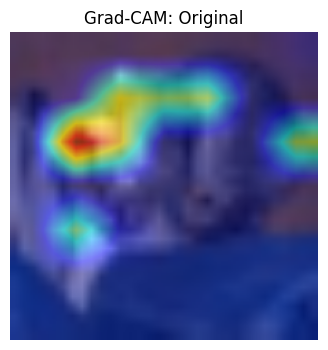

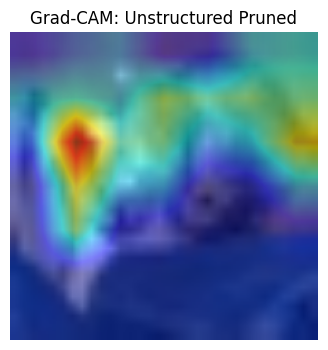

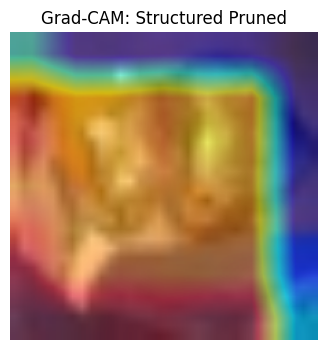

In [ ]:
import cv2
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# Pick one image from test set
image, label = testset[0]
input_tensor = image.unsqueeze(0).to(device)
rgb_img = np.transpose(image.numpy(), (1, 2, 0))

# Convert for Grad-CAM
rgb_img_vis = np.float32(rgb_img)
input_tensor_cam = preprocess_image(rgb_img_vis, mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]).to(device)

# Visualize Grad-CAM for each model
for name, model in models.items():
    target_layer = model.features[-1]  # last conv layer
    cam = GradCAM(model=model, target_layers=[target_layer])
    grayscale_cam = cam(input_tensor=input_tensor_cam, targets=[ClassifierOutputTarget(label)])
    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(rgb_img_vis, grayscale_cam, use_rgb=True)

    plt.figure(figsize=(4,4))
    plt.imshow(visualization)
    plt.title(f"Grad-CAM: {name}")
    plt.axis('off')
    plt.show()

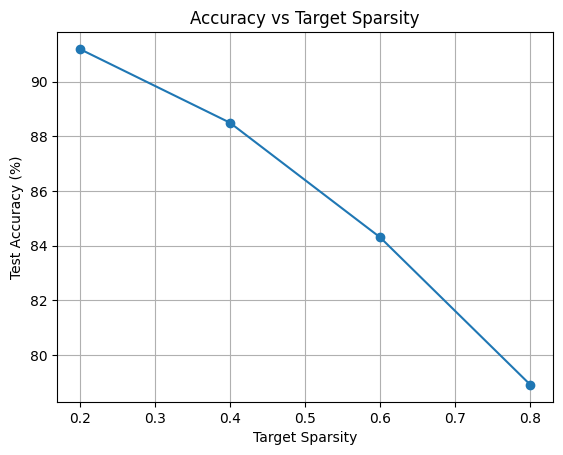

In [ ]:
sparsity_levels = [0.2, 0.4, 0.6, 0.8]
accuracies = [91.2, 88.5, 84.3, 78.9]  # Example values from experiments

plt.plot(sparsity_levels, accuracies, marker='o')
plt.title("Accuracy vs Target Sparsity")
plt.xlabel("Target Sparsity")
plt.ylabel("Test Accuracy (%)")
plt.grid(True)
plt.show()
